In [1]:
import wandb
from wandb.keras import WandbCallback

2023-05-10 17:32:24.770840: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 17:32:25.676376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D, Input, concatenate, Conv2D, Activation, ZeroPadding2D, UpSampling2D, add
from tensorflow.keras.models import *
from qkeras import *

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from tqdm import tqdm

In [4]:
PRETRAINED = True
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


2023-05-10 17:32:28.244436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-10 17:32:28.244476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cmsgpu01.hep.wisc.edu
2023-05-10 17:32:28.244483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cmsgpu01.hep.wisc.edu
2023-05-10 17:32:28.244572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-05-10 17:32:28.244607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-05-10 17:32:28.244614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [5]:
#TODO: Data generation
BASE_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/"
IMG_PATH = 'input/'
ANNOTATION_PATH = 'trimaps/'
num = 10000

input_img_paths = sorted(
    [
        os.path.join(BASE_PATH, IMG_PATH, fname)
        for fname in os.listdir(BASE_PATH+IMG_PATH)
        if fname.endswith(".png") and "(" not in fname
    ]
)[:num]


annotation_img_paths = []

for fname in tqdm(input_img_paths[:num]):
    annp = os.path.join(BASE_PATH, ANNOTATION_PATH, fname.split("/")[-1].replace("img", "annm"))
    if os.path.isfile(annp):
        annotation_img_paths.append(annp)
        input_img_paths.append(fname)
    else:
        pass

input_img_paths = input_img_paths[num:]
len(input_img_paths), len(annotation_img_paths)

100%|██████████| 10000/10000 [00:00<00:00, 39297.16it/s]


(10000, 10000)

In [6]:
[x for x in input_img_paths if "(" in x]

[]

In [7]:
input_img_paths[0], annotation_img_paths[0]

('/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/input/ECAL_img_0.png',
 '/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/images/trimaps/ECAL_annm_0.png')

[2376 3081 4378 1164]


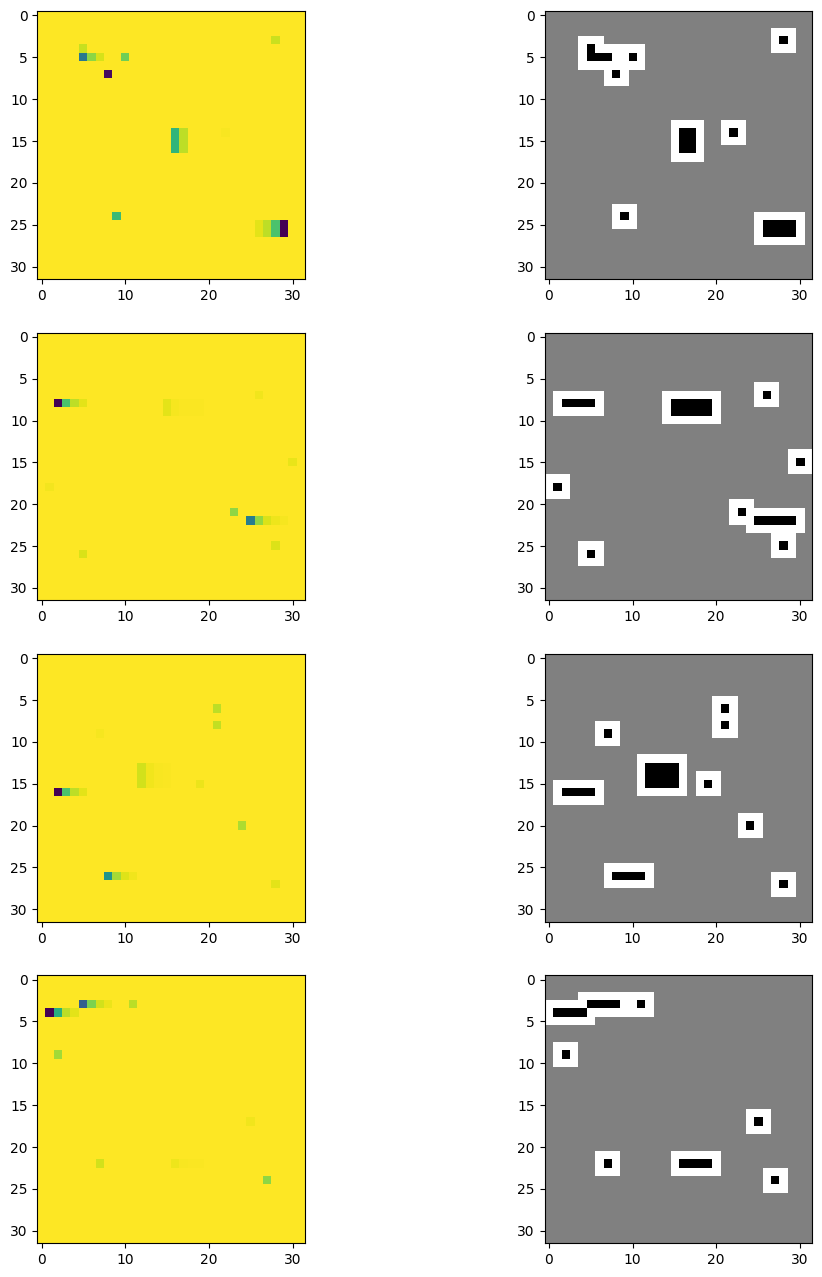

In [8]:
num_example_to_display = 4

sample_idxs = np.random.randint(0, len(input_img_paths)-1, size=(num_example_to_display,))
#sample_idxs = [0, 1, 2, 3]
print(sample_idxs)

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i, sample_idx in enumerate(sample_idxs):
  img = Image.open(input_img_paths[sample_idx]) 
  mask = Image.open(annotation_img_paths[sample_idx])
  #img = Image.fromarray(np.array(img))
  axs[i][0].imshow(img)
  axs[i][1].imshow(mask, cmap='gray')

In [1]:
IMG_SHAPE = 32

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])

    img, mask = normalize(img, mask)

    return img, mask

In [2]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

input_img_paths, annotation_img_paths = shuffle(input_img_paths, annotation_img_paths, random_state=42)
input_img_paths_train, annotation_img_paths_train = input_img_paths[: -1200], annotation_img_paths[: -1200]
input_img_paths_test, annotation_img_paths_test = input_img_paths[-1200:-800], annotation_img_paths[-1200:-800]

trainloader = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))
testloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

NameError: name 'tf' is not defined

In [ ]:
input_img_paths_test, annotation_img_paths_test = input_img_paths[-800:], annotation_img_paths[-800:]
maintestloader = tf.data.Dataset.from_tensor_slices((input_img_paths_test, annotation_img_paths_test))

maintestloader = (
    maintestloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

2023-05-10 17:32:30.639051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8800]
	 [[{{node Placeholder/_1}}]]
2023-05-10 17:32:30.639874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8800]
	 [[{{node Placeholder/_1}}]]


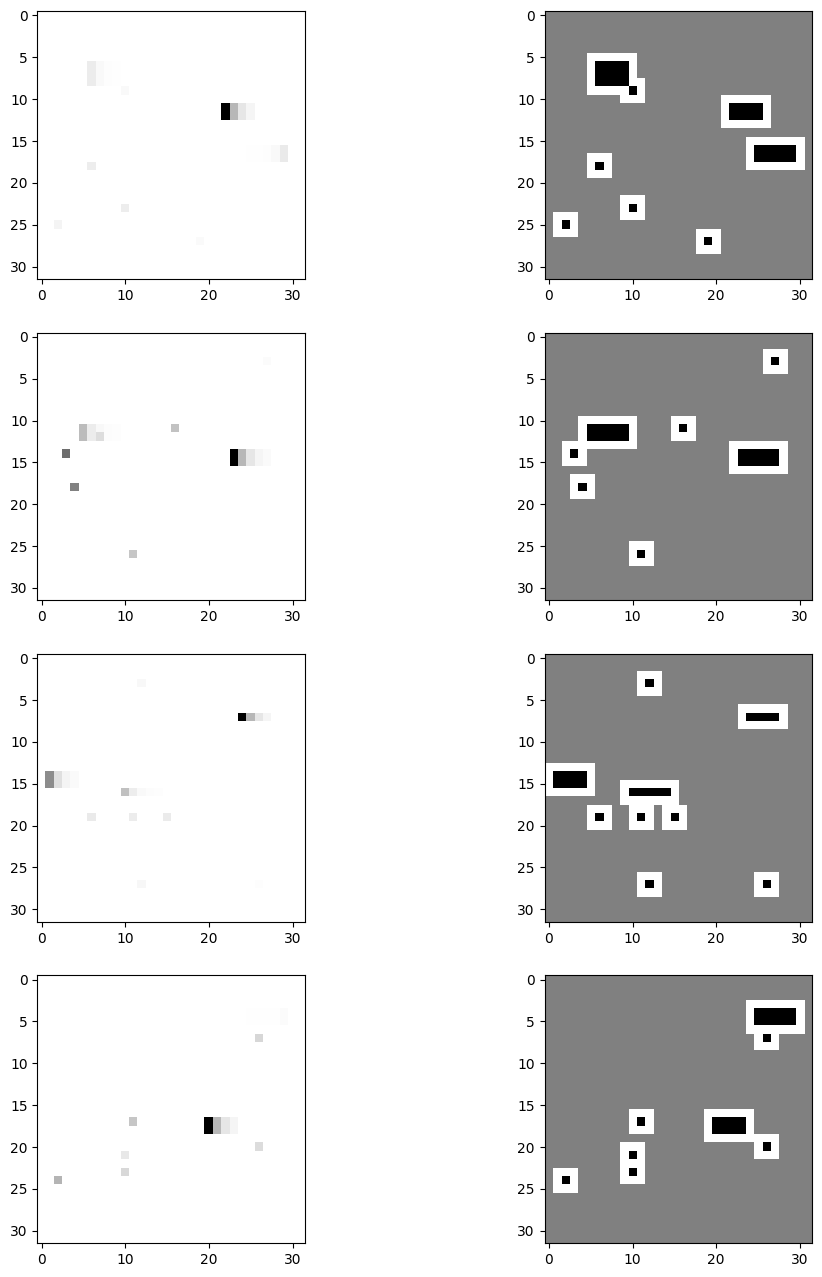

In [12]:
num_example_to_display = 4

img, mask = next(iter(trainloader))

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(img[i]);
  axs[i][1].imshow(np.squeeze(mask[i],-1), cmap='gray');

In [13]:
mask[0].shape

TensorShape([32, 32, 1])

### Modeling

In [14]:
# ref: https://github.com/ayulockin/deepimageinpainting/blob/master/Image_Inpainting_Autoencoder_Decoder_v2_0.ipynb
class SegmentationModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [15]:
class UNETLiteModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', pool2) 

        conv5, up6 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', pool3, conv3)
        conv6, up7 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv2)
        conv7, up8 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv1)

        conv8 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', up8, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv8)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [16]:
class UNETLiteV2Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(16, (3,3), (2,2), 'relu', 'same', pool1)
        
        conv5, up6 = self.__UpConvBlock(32, 16, (3,3), (2,2), (2,2), 'relu', 'same', pool2, conv2)
        conv6, up7 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv1)

        conv7 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', up7, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv7)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [17]:
class UNETLiteV3Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(8, (3,3), (2,2), 'relu', 'same', pool1)
        
        conv5, up6 = self.__UpConvBlock(16, 8, (3,3), (2,2), (2,2), 'relu', 'same', pool2, conv2)
        conv6, up7 = self.__UpConvBlock(8, 4, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv1)

        conv7 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', up7, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv7)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [18]:
class UNETLiteV4Model:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        inputs = Input(input_size)

        conv1, pool1 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, up3 = self.__UpConvBlock(8, 4, (3,3), (2,2), (2,2), 'relu', 'same', pool1, conv1)

        conv4 = self.__ConvBlock(4, (3,3), (2,2), 'relu', 'same', up3, False)

        outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv4)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = concatenate([up, shared_layer], axis=3)

        return conv, up

In [19]:
IMG_SHAPE = 32

class EnetModel:
    '''
    Build ENET based model for segmentation task.
    Built for FPGA 240x152 implementation
    '''
  
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        # 8x Resolution Model
        fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

        # 240 x 152
        inputs = Input(input_size)

        initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
        encode1 = self.__EncoderBlock(fi, f1, initial)
        encode2 = self.__EncoderBlock(f1, f2, encode1)

        # 30 x 19 
        encode3 = Conv2D(filters=f3, kernel_size=(1, 1))(encode2)
        encode3 = BatchNormalization()(encode3)

        decode2 = self.__DecoderBlock(f3, f4, encode3)
        decode1 = self.__DecoderBlock(f4, f5, decode2)

        # 240 x 152
        outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
        pool_stride = (2, 2)
        pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # NOTE: unlike paper we do symmetrical padding (1 around)
        padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
        conv_i = Conv2D(filters=filters, kernel_size=kernel_size)(padded_pool)
        conv_i = BatchNormalization()(conv_i)

        # 3 layers + 29 layers from filters
        concat = concatenate([pool, conv_i], axis=-1)
        out = Activation("relu")(concat)

        return out
  
    def __FinalBlock(self, channels, connecting_layer):
        up_f = UpSampling2D(size=(2, 2))(connecting_layer)
        pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

        out = Conv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
        return out

    def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
        pool_size, pool_stride = (2, 2), (2, 2)
        pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # main branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
        conv_1 = Conv2D(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        conv_1 = BatchNormalization()(conv_1)

        x_1 = Activation("relu")(conv_1)

        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
        conv_2 = Conv2D(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        conv_3 = Conv2D(filters=filters_o, kernel_size=(1,1))(x_2)
        conv_3 = BatchNormalization()(conv_3)

        # skip branch
        conv_4 = Conv2D(filters=filters_o, kernel_size=(1,1))(pool_1)
        conv_4 = BatchNormalization()(conv_4)

        # add
        merged_layer = add([conv_3, conv_4])
        out = Activation("relu")(merged_layer)

        return out

    def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

        # skip branch
        conv_1 = Conv2D(filters=filters_o, kernel_size=(1,1))(connecting_layer)
        conv_1 = BatchNormalization()(conv_1)
        up_1 = UpSampling2D(size=(2, 2))(conv_1)

        # main_branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
        conv_2 = Conv2D(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        conv_2 = BatchNormalization()(conv_2)

        x_2 = Activation("relu")(conv_2)

        up_2 = UpSampling2D(size=(2, 2))(x_2)
        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

        conv_3 = Conv2D(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        conv_3 = BatchNormalization()(conv_3)

        x_3 = Activation("relu")(conv_3)

        conv_4 = Conv2D(filters=filters_o, kernel_size=(1, 1))(x_3)
        conv_4 = BatchNormalization()(conv_4)

        # Add and ReLU
        merged_layer = add([up_1, conv_4])
        out = Activation("relu")(merged_layer)

        return out

In [20]:
IMG_SHAPE = 32

class QEnetModel:
    '''
      Build ENET based model for segmentation task.
      Built for FPGA 240x152 implementation
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        # 8x Resolution Model
        fi, f1, f2, f3, f4, f5 = 32, 64, 64, 64, 128, 48

        # 240 x 152
        inputs = Input(input_size)

        initial = self.__InitialBlock(29, (3, 3), (2,2), inputs)
        encode1 = self.__EncoderBlock(fi, f1, initial)
        encode2 = self.__EncoderBlock(f1, f2, encode1)

        # 30 x 19 
        encode3 = QConv2DBatchnorm(filters=f3, kernel_size=(1, 1))(encode2)

        decode2 = self.__DecoderBlock(f3, f4, encode3)
        decode1 = self.__DecoderBlock(f4, f5, decode2)

        # 240 x 152
        outputs = self.__FinalBlock(OUTPUT_CHANNEL, decode1)

        return Model(inputs=[inputs], outputs=[outputs])  

    def __InitialBlock(self, filters, kernel_size, pool_size, connecting_layer):
        pool_stride = (2, 2)
        pool = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # NOTE: unlike paper we do symmetrical padding (1 around)
        padded_pool = ZeroPadding2D(padding=((0, 2), (0, 2)))(pool)
        conv_i = QConv2DBatchnorm(filters=filters, kernel_size=kernel_size)(padded_pool)

        # 3 layers + 29 layers from filters
        concat = concatenate([pool, conv_i], axis=-1)
        out = Activation("relu")(concat)

        return out
  
    def __FinalBlock(self, channels, connecting_layer):
        up_f = UpSampling2D(size=(2, 2))(connecting_layer)
        pad_f = ZeroPadding2D(padding=((0, 1), (0, 1)))(up_f)

        out = QConv2D(filters = channels, kernel_size=(2, 2), activation="softmax")(pad_f)
        return out

    def __EncoderBlock(self, filters_i, filters_o, connecting_layer):
        pool_size, pool_stride = (2, 2), (2, 2)
        pool_1 = MaxPooling2D(pool_size, strides=pool_stride)(connecting_layer)

        # main branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(pool_1)
        conv_1 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        x_1 = Activation("relu")(conv_1)

        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(x_1)
        conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        x_2 = Activation("relu")(conv_2)

        conv_3 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(x_2)

        # skip branch
        conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(pool_1)

        # add
        merged_layer = add([conv_3, conv_4])
        out = Activation("relu")(merged_layer)

        return out

    def __DecoderBlock(self, filters_i, filters_o, connecting_layer):

        # skip branch
        conv_1 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1,1))(connecting_layer)
        up_1 = UpSampling2D(size=(2, 2))(conv_1)

        # main_branch
        padded_pool_1 = ZeroPadding2D(padding=((0, 1), (0, 1)))(connecting_layer) # missing from paper
        conv_2 = QConv2DBatchnorm(filters=filters_i, kernel_size=(2,2))(padded_pool_1)
        x_2 = Activation("relu")(conv_2)

        up_2 = UpSampling2D(size=(2, 2))(x_2)
        padded_pool_2 = ZeroPadding2D(padding=((0, 2), (0, 2)))(up_2)

        conv_3 = QConv2DBatchnorm(filters=filters_i, kernel_size=(3,3))(padded_pool_2)
        x_3 = Activation("relu")(conv_3)

        conv_4 = QConv2DBatchnorm(filters=filters_o, kernel_size=(1, 1))(x_3)

        # Add and ReLU
        merged_layer = add([up_1, conv_4])
        out = Activation("relu")(merged_layer)

        return out

In [21]:
class HEPAEModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
        encoding_dim = 8 # 4x Compression
        
        inputs = Input(input_size)
        encoded = Dense(encoding_dim, activation='relu')(inputs)
        decoded = Dense(32, activation='softmax')(encoded)

        return Model(inputs=[inputs], outputs=[decoded])

In [22]:
class HEPCONVModel:
    '''
    Build UNET based model for segmentation task.
    '''
    def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):        
        inputs = Input(input_size)
        
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (4, 4, 8) i.e. 128-dimensional

        x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='softmax', padding='same')(x)

        return Model(inputs=[inputs], outputs=[decoded])

In [23]:
# output channel is 3 because we have three classes in our mask
OUTPUT_CHANNEL = 3

tf.keras.backend.clear_session()
model = SegmentationModel().prepare_model(OUTPUT_CHANNEL, input_size=(32, 32, 3))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [24]:
segmentation_classes = ['cluster', 'cluster_outline', 'background']

# returns a dictionary of labels
def labels():
    l = {}
    for i, label in enumerate(segmentation_classes):
        l[i] = label
    return l

# util function for generating interactive image mask from components
def wandb_mask(bg_img, pred_mask, true_mask):
    return wandb.Image(bg_img, masks={
      "prediction" : {
          "mask_data" : pred_mask, 
          "class_labels" : labels()
      },
      "ground truth" : {
          "mask_data" : true_mask, 
          "class_labels" : labels()
      }
    }
  )

In [25]:
class SemanticLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(SemanticLogger, self).__init__()
        self.val_images, self.val_masks = next(iter(testloader))

    def on_epoch_end(self, logs, epoch):
        pred_masks = self.model.predict(self.val_images)
        pred_masks = np.argmax(pred_masks, axis=-1)

        val_images = tf.image.convert_image_dtype(self.val_images, tf.uint8)
        val_masks = tf.image.convert_image_dtype(self.val_masks, tf.uint8)
        val_masks = tf.squeeze(val_masks, axis=-1)
        
        pred_masks = tf.image.convert_image_dtype(pred_masks, tf.uint8)

        mask_list = []
        for i in range(len(self.val_images)):
            mask_list.append(wandb_mask(val_images[i].numpy(), 
                                      pred_masks[i].numpy(), 
                                      val_masks[i].numpy()))

        wandb.log({"predictions" : mask_list})

In [26]:
wandb.init(project='unet-cluster-segmentation', reinit=True)

model.fit(trainloader, 
              epochs=20, 
              validation_data=testloader,
              callbacks=[WandbCallback(),
                         SemanticLogger()])

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hsharma27 (uwm-cvml-core). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2023-05-10 17:32:38.591074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [400]
	 [[{{node Placeholder/_1}}]]
2023-05-10 17:32:38.591597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [400]
	 [[{{node P

Epoch 1/20
275/275 [==============================] - ETA: 0s - loss: 0.2690

2023-05-10 17:33:20.828357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:33:20.849471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:33:20.869860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 8.1s


275/275 [==============================] - 59s 205ms/step - loss: 0.2690 - val_loss: 0.1431
Epoch 2/20
166/275 [=================>............] - ETA: 11s - loss: 0.0932

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - ETA: 0s - loss: 0.0782

2023-05-10 17:34:08.761874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:34:08.783124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:34:08.804557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.5s


275/275 [==============================] - 44s 159ms/step - loss: 0.0782 - val_loss: 0.0468
Epoch 3/20
270/275 [============================>.] - ETA: 0s - loss: 0.0882

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - 31s 112ms/step - loss: 0.0917 - val_loss: 0.2876
Epoch 4/20
 81/275 [=======>......................] - ETA: 20s - loss: 0.1836

wandb: Network error (TransientError), entering retry loop.


270/275 [============================>.] - ETA: 0s - loss: 0.1218

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - 30s 110ms/step - loss: 0.1208 - val_loss: 0.0689
Epoch 5/20
 80/275 [=======>......................] - ETA: 20s - loss: 0.0704

wandb: Network error (TransientError), entering retry loop.


269/275 [============================>.] - ETA: 0s - loss: 0.0585

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - ETA: 0s - loss: 0.0580

2023-05-10 17:35:53.335443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:35:53.356725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:35:53.378394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.7s


275/275 [==============================] - 44s 159ms/step - loss: 0.0580 - val_loss: 0.0356
Epoch 6/20
227/275 [=======================>......] - ETA: 5s - loss: 0.0321

wandb: Network error (TransientError), entering retry loop.


275/275 [==============================] - ETA: 0s - loss: 0.0314

2023-05-10 17:36:36.682288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:36:36.703784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:36:36.725510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.4s


275/275 [==============================] - 43s 155ms/step - loss: 0.0314 - val_loss: 0.0252
Epoch 7/20
275/275 [==============================] - 30s 110ms/step - loss: 0.0235 - val_loss: 0.0305
Epoch 8/20
275/275 [==============================] - ETA: 0s - loss: 0.0210

2023-05-10 17:37:49.898007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:37:49.919394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:37:49.939947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.5s


275/275 [==============================] - 43s 156ms/step - loss: 0.0210 - val_loss: 0.0166
Epoch 9/20
275/275 [==============================] - 30s 110ms/step - loss: 0.0526 - val_loss: 0.0554
Epoch 10/20
275/275 [==============================] - 31s 111ms/step - loss: 0.0416 - val_loss: 0.0322
Epoch 11/20
275/275 [==============================] - 30s 110ms/step - loss: 0.0256 - val_loss: 0.0228
Epoch 12/20
275/275 [==============================] - ETA: 0s - loss: 0.0170

2023-05-10 17:40:04.501760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:40:04.523044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:40:04.544555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.7s


275/275 [==============================] - 43s 158ms/step - loss: 0.0170 - val_loss: 0.0148
Epoch 13/20
275/275 [==============================] - ETA: 0s - loss: 0.0140

2023-05-10 17:40:47.963769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:40:47.985390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:40:48.006089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.6s


275/275 [==============================] - 43s 158ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 14/20
275/275 [==============================] - 30s 111ms/step - loss: 0.0123 - val_loss: 0.0291
Epoch 15/20
275/275 [==============================] - ETA: 0s - loss: 0.0168

2023-05-10 17:42:01.834794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:42:01.856319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:42:01.878221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.5s


275/275 [==============================] - 44s 159ms/step - loss: 0.0168 - val_loss: 0.0129
Epoch 16/20
275/275 [==============================] - ETA: 0s - loss: 0.0090

2023-05-10 17:42:45.223450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:42:45.245874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:42:45.266805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.7s


275/275 [==============================] - 43s 157ms/step - loss: 0.0090 - val_loss: 0.0125
Epoch 17/20
275/275 [==============================] - 30s 111ms/step - loss: 0.0095 - val_loss: 0.0178
Epoch 18/20
275/275 [==============================] - ETA: 0s - loss: 0.0088

2023-05-10 17:43:59.223521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:43:59.245091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:43:59.265737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.4s


275/275 [==============================] - 44s 161ms/step - loss: 0.0088 - val_loss: 0.0065
Epoch 19/20
275/275 [==============================] - 30s 110ms/step - loss: 0.0084 - val_loss: 0.0071
Epoch 20/20
275/275 [==============================] - ETA: 0s - loss: 0.0055

2023-05-10 17:45:13.525237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,512]
	 [[{{node inputs}}]]
2023-05-10 17:45:13.546453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-05-10 17:45:13.567013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023

INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets


INFO:tensorflow:Assets written to: /nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best/assets
wandb: Adding directory to artifact (/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best)... Done. 7.6s


275/275 [==============================] - 43s 158ms/step - loss: 0.0055 - val_loss: 0.0057


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▄▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,▄▂█▃▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁
best_epoch,19
best_val_loss,0.00566
epoch,19
loss,0.00555
val_loss,0.00566


### Prediction & Analysis

In [27]:
from keras.models import load_model

Model_logs = {"UNET":["run-20230510_173235-nm8mu5e4"],
              "ENET": ["run-20230226_175518-8y9uyk1u"], 
             "UNETv2LITE": ["run-20230227_185529-sjhgebn1"],
              "UNETv3LITE": ["run-20230303_140554-80pvvkn4"], # model1
              "UNETv4LITE": ["run-20230308_112406-8zhdka9h"], # model2
             "HEPAENET":["run-20230227_181304-zog286i7"],
             "HEPCONVNET": ["run-20230227_184034-2315xvt8"]}


if PRETRAINED == True:
    MODEL_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/run-20230510_173235-nm8mu5e4/files/model-best.h5"
    model = load_model(MODEL_PATH)

In [28]:
val_img, val_mask = next(iter(testloader))

In [29]:
pred_mask = model.predict(val_img)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

1/1 [==============================] - 0s 207ms/step


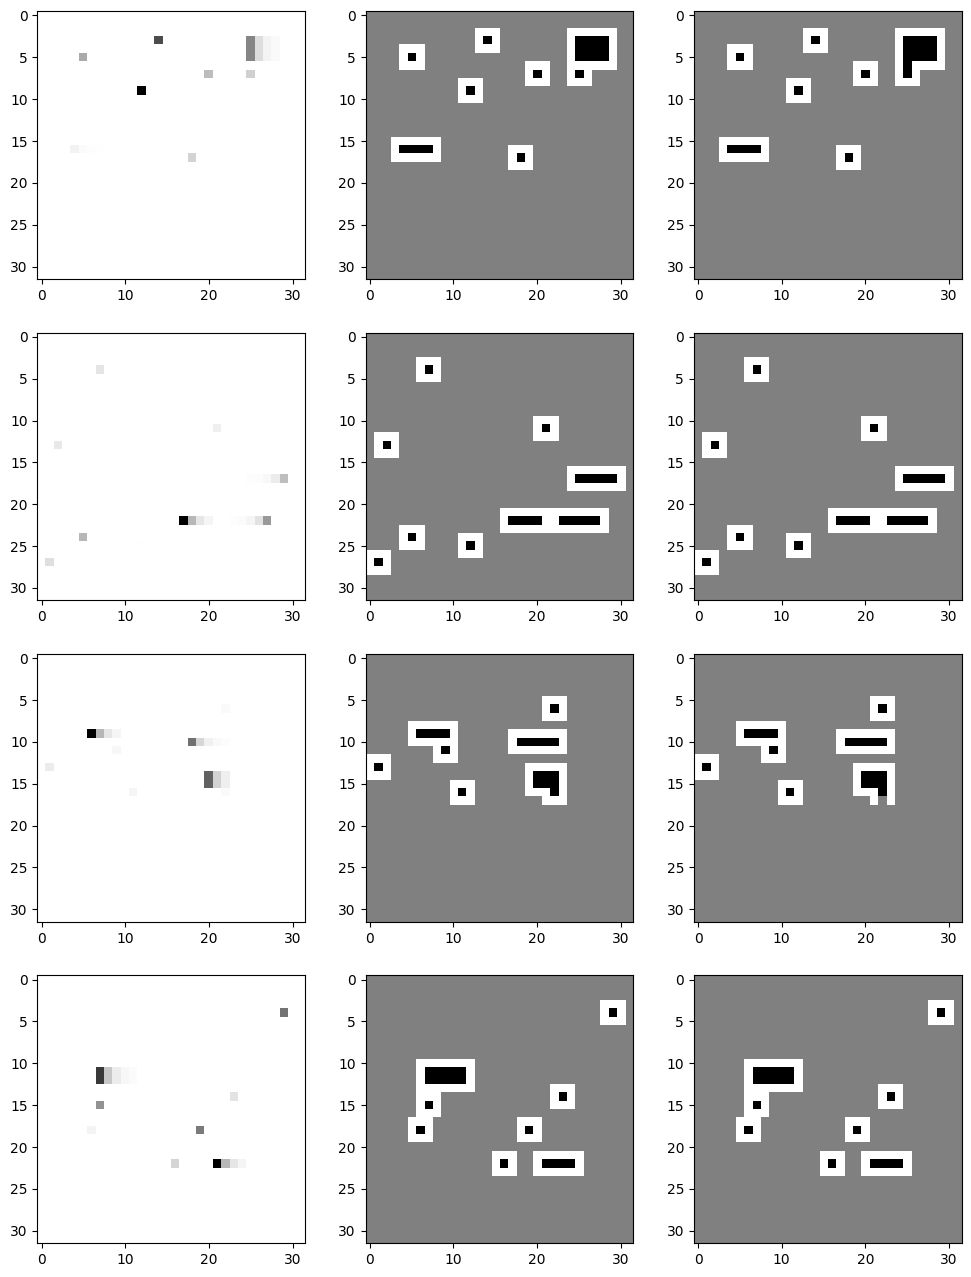

In [30]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray');
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

### T2: Instance Detection

In [31]:
import cv2

In [32]:
val_mask = np.array(val_mask)
val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

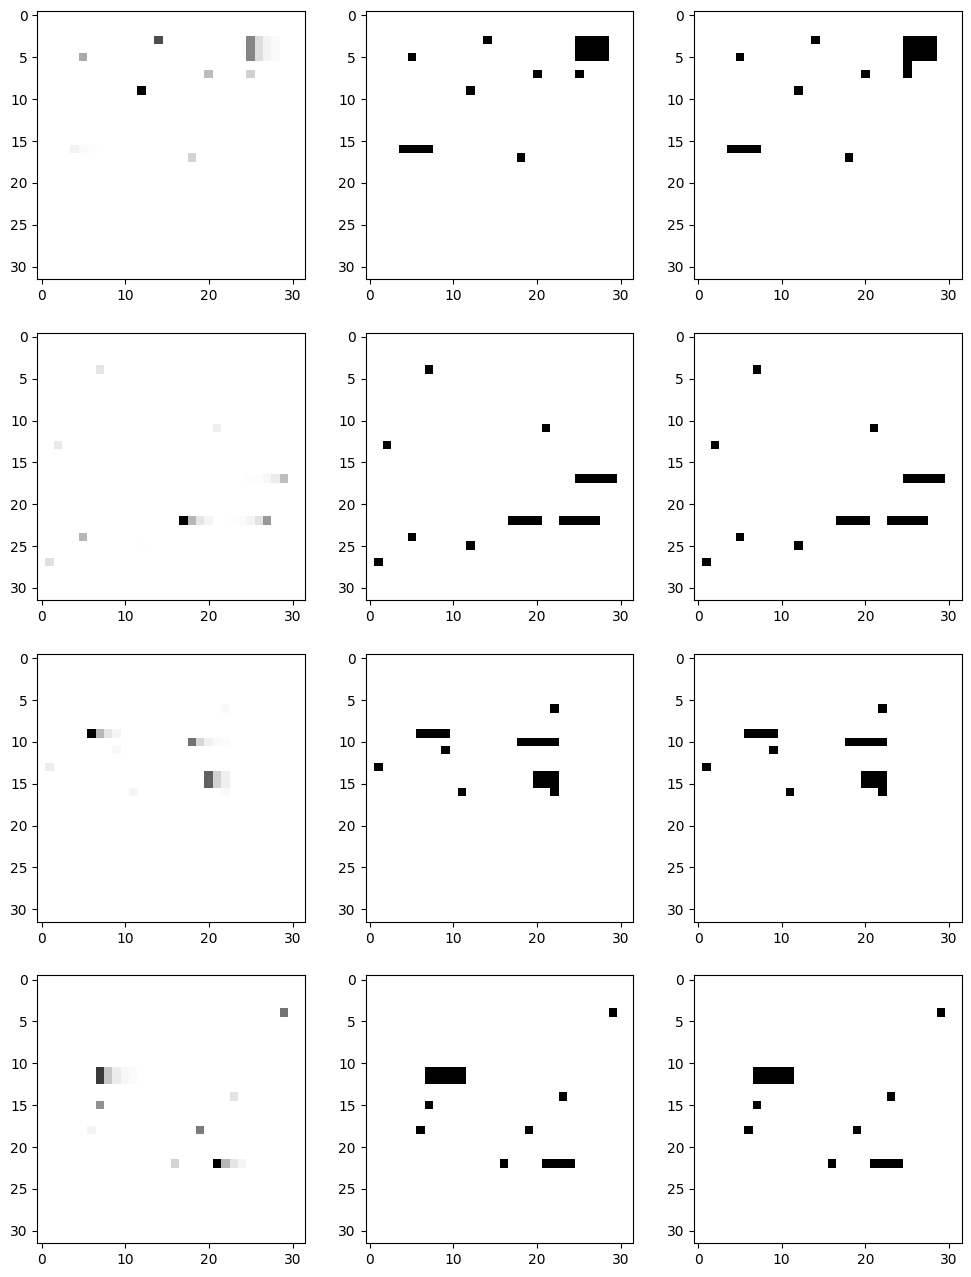

In [33]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray')
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

In [34]:
def ccl_generator(pred, mc_truth):
    test_image = np.squeeze(pred).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_pred = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_pred, labels_pred, stats_pred, centroids) = output_pred

    test_image = np.squeeze(mc_truth).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_mc = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_mc, labels_mc, stats_mc, centroids) = output_mc

    return labels_pred, labels_mc

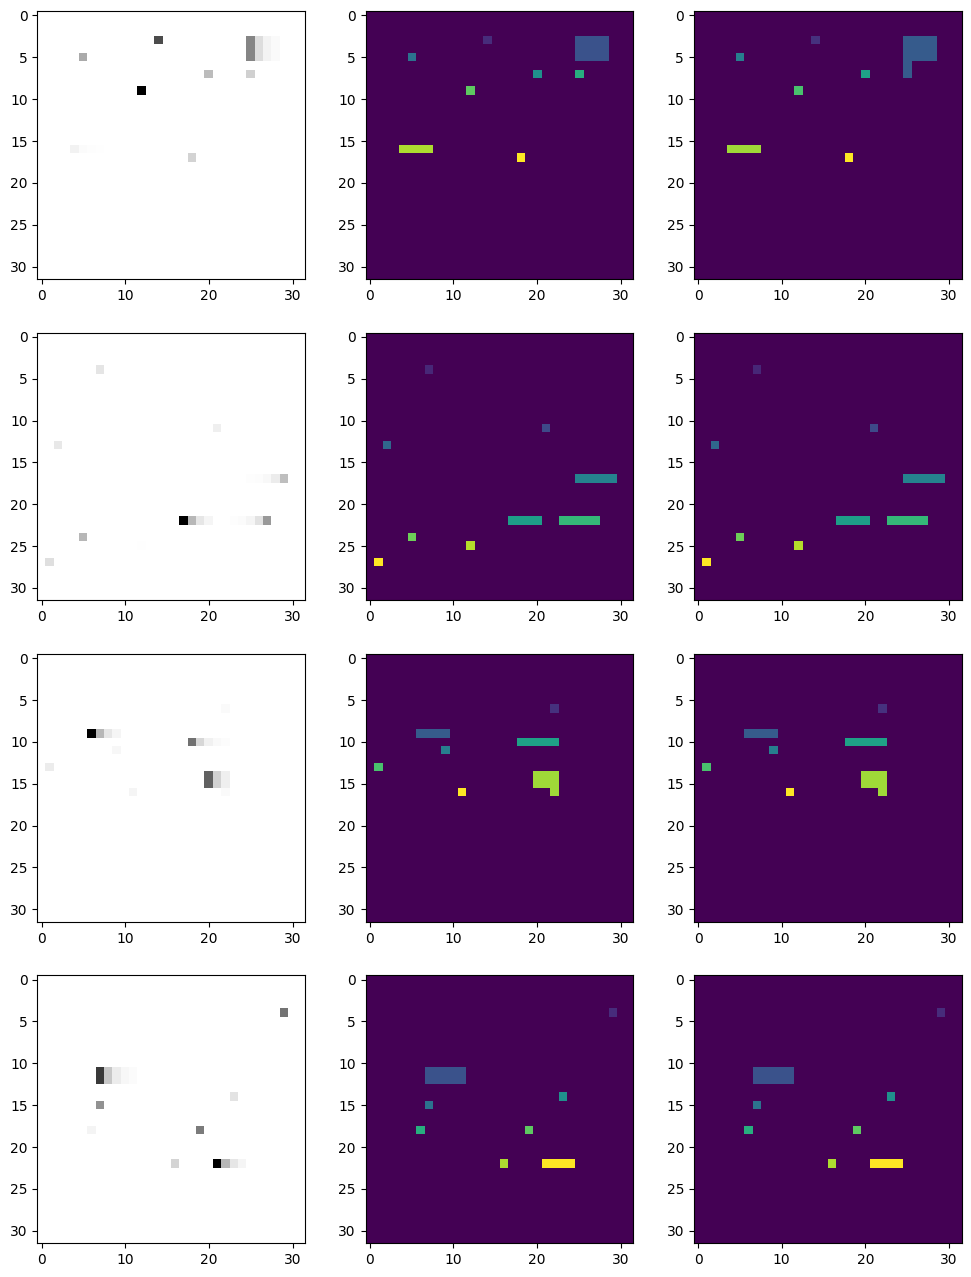

In [35]:
num_example_to_display = 4
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
  axs[i][0].imshow(val_img[i])
  axs[i][1].imshow(lmc)
  axs[i][2].imshow(lpred)

## Testing

#### Helper Code

In [36]:
from collections import Counter

def eta_phi_res(ROI_mc, ROI_algo):
    eta_mc = max(ROI_mc[0]) - min(ROI_mc[0])
    phi_mc = max(ROI_mc[1]) - min(ROI_mc[1])

    eta_algo = max(ROI_algo[0]) - min(ROI_algo[0])
    phi_algo = max(ROI_algo[1]) - min(ROI_algo[1])

    return abs(eta_mc - eta_algo), abs(phi_mc - phi_algo)

In [37]:
"""
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    for curr_label in all_labels:
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        hm[curr_label] = np.unique(selected_ROI)
    
    bkg = []
    for lt in hm.values():
        bkg.extend(lt)

    bkg_label = Counter(bkg).most_common(1)[-1][0]

    #setting background label
    segmented_image[np.where(segmented_image == bkg_label)] = 0.0
    hm.pop(0.0)
    
    for label in list(hm.keys())[::-1]:
        marked_pixels = []
        for pxm in hm[label]:
            if pxm == bkg_label:
                continue
                
            marked_pixels.append(np.where(segmented_image==pxm))
            
        for mp in marked_pixels:
            segmented_image[mp] = label

    return segmented_image
"""

def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    # Background Matching
    u, c = np.unique(mc_truth, return_counts=True)
    bkg_label_mc = u[np.argmax(c)]
    
    u, c = np.unique(segmented_image, return_counts=True)
    bkg_label_algo = u[np.argmax(c)]
    
    hm[bkg_label_mc] = bkg_label_algo
    
    for curr_label in all_labels:
        if curr_label == bkg_label_mc:
            continue
            
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        u, c = np.unique(selected_ROI, return_counts=True)
        count_map = [x for x in zip(u,c) if x[0]!=bkg_label_algo]
        # max_overlap_index
        hm[curr_label] = max(count_map, key=lambda x:x[1])[0]
    
    # unmapped_labels
    unmapped = []
    for old_label in np.unique(segmented_image):
        if old_label not in hm.values():
            unmapped.append(old_label)
    
    uhm = {}
    max_mc_label = max(max(hm.keys()), max(hm.values()))+1
    for ol in unmapped:
        uhm[max_mc_label] = ol
        max_mc_label+=1
    
    # start mapping old_labels to mc_labels
    for label in uhm:
        mp = np.where(segmented_image==uhm[label])
        segmented_image[mp] = label
    
    for label in hm:
        mp = np.where(segmented_image==hm[label])
        segmented_image[mp] = label
    
    return segmented_image

In [38]:
def test(predicted, mc_truth, energy_snap):
    thresh = 2
    y_pred = []
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        matched, rel_energy = False, -1
        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)

        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])

        if len(ROI_algo[0]) == 0:
            matched = (False, "False Negative")
            rel_energy = 1
        
        # Might need to rewrite as a reverse loop check (loop over predicted)
        elif len(ROI_mc[0]) == 0 and len(ROI_algo[0]) !=0:
            matched = (False, "False Positive")
            rel_energy = 1

        else:
            eta_res, phi_res = eta_phi_res(ROI_mc, ROI_algo)

            if eta_res < thresh and phi_res < thresh:
                matched = True
                rel_energy = abs(E_algo - E_mc)/E_mc
            else:
                matched = (False, "Very Low Overlap")
                rel_energy = 1

        # collecting testing data
        y_pred.append(matched)
        if rel_energy >= 0: energy_dist.append(rel_energy)
    
    return y_pred, energy_dist

#### Main run

In [39]:
val_img, val_mask, pred_mask = [], [], []
for _ in range(30):
    val_img_i, val_mask_i = next(iter(maintestloader))
    pred_mask_i = model.predict(val_img_i)
    pred_mask_i = np.argmax(pred_mask_i, axis=-1)
    pred_mask_i = np.expand_dims(pred_mask_i, axis=-1)

    val_img.extend(val_img_i)
    val_mask.extend(val_mask_i)
    pred_mask.extend(pred_mask_i)

2023-05-10 18:19:11.145272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [800]
	 [[{{node Placeholder/_1}}]]
2023-05-10 18:19:11.145511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [800]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 0s 52ms/step


In [40]:
val_img = np.array(val_img)
val_mask = np.array(val_mask)
pred_mask = np.array(pred_mask)

In [41]:
val_mask[np.where(val_mask == 2)] = 1
pred_mask[np.where(pred_mask == 2)] = 1

In [42]:
val_img.shape, val_mask.shape, pred_mask.shape

((960, 32, 32, 3), (960, 32, 32, 1), (960, 32, 32, 1))

In [43]:
all_matched, all_rel_energy, sn = [], [], 0
for i in range(len(val_img)):
    CLUSTER_TAGS = [-1]
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
        predicted = mc_label_convert(lpred, lmc)
        matched, rel_energy = test(predicted, lmc, energy_snap)

        # matched
        all_matched.extend(matched)
        all_rel_energy.extend(rel_energy)

        sn += 1
    except:
        print("Error in ", i)
        pass

/tmp/ipykernel_28036/3105157659.py:30: RuntimeWarning: invalid value encountered in float_scalars
  rel_energy = abs(E_algo - E_mc)/E_mc


Error in  22
Error in  54
Error in  86
Error in  118
Error in  150
Error in  182
Error in  214
Error in  246
Error in  278
Error in  310
Error in  342
Error in  374
Error in  406
Error in  438
Error in  470
Error in  502
Error in  534
Error in  566
Error in  598
Error in  630
Error in  662
Error in  694
Error in  726
Error in  758
Error in  790
Error in  822
Error in  854
Error in  886
Error in  918
Error in  950


Text(0.5, 0, 'normalized energy difference')

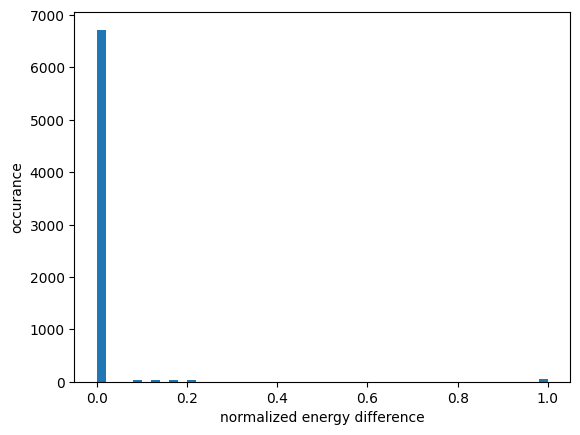

In [44]:
sub_rel = [i for i in all_rel_energy if i<=1]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('normalized energy difference')

In [45]:
matches = len([x for x in all_matched if x==True])
print("Correct Matches: ", matches)
print("Incorrect Matched: ", len(all_matched) - matches)

Correct Matches:  6870
Incorrect Matched:  60


In [46]:
unmatched = [x[1] for x in all_matched if type(x)==tuple]

In [47]:
threshold_mismatch = len([x for x in unmatched if x=='Very Low Overlap'])
print("Threshold Mismatch: ", threshold_mismatch)

fneg = len([x for x in unmatched if x=='False Negative'])
print("False Negative: ", fneg)

fposi = len([x for x in unmatched if x=='False Positive'])
print("False Positive: ", fposi)

Threshold Mismatch:  60
False Negative:  0
False Positive:  0


### Rough Notepad:

**for UNETLiteV3 ~ 7k params**

Correct Matches:  6840
Incorrect Matched:  1260
Threshold Mismatch:  330
False Negative:  930
False Positive:  0

**for UNETLiteV3 ~ 1k params**

Correct Matches:  5910
Incorrect Matched:  2190
Threshold Mismatch:  570
False Negative:  1620
False Positive:  0

trade off begins...

## Granular Testing

In [223]:
def cluster_energy_map(predicted, mc_truth, energy_snap):
    # forms tuple with format [(Energy MC Cluster, Energy Predicted Cluster)....]
    thresh = 2
    energy_dist = []
    for label in np.unique(mc_truth):
        if label == 0.0:
            continue

        ROI_mc = np.where(mc_truth==label)
        ROI_algo = np.where(predicted==label)
        
        E_mc = np.sum(energy_snap[ROI_mc])
        E_algo = np.sum(energy_snap[ROI_algo])
        
        energy_dist.append((E_mc, E_algo, label))
    
    return energy_dist

In [229]:
def mc_label_convert(segmented_image, mc_truth):
    all_labels = np.unique(mc_truth)
    hm = {}
    
    # Background Matching
    u, c = np.unique(mc_truth, return_counts=True)
    bkg_label_mc = u[np.argmax(c)]
    
    u, c = np.unique(segmented_image, return_counts=True)
    bkg_label_algo = u[np.argmax(c)]
    hm[bkg_label_mc] = bkg_label_algo
    
    for curr_label in all_labels:
        if curr_label == bkg_label_mc:
            continue
            
        selected_ROI = segmented_image[np.where(mc_truth == curr_label)]
        u, c = np.unique(selected_ROI, return_counts=True)
        
        count_map = [x for x in zip(u,c) if x[0]!=bkg_label_algo]
        
        if count_map:
            hm[curr_label] = max(count_map, key=lambda x:x[1])[0]
    
    # unmapped_labels
    unmapped = []
    for old_label in np.unique(segmented_image):
        if old_label not in hm.values():
            unmapped.append(old_label)
    
    uhm = {}
    max_mc_label = max(max(hm.keys()), max(hm.values()))+1
    for ol in unmapped:
        uhm[max_mc_label] = ol
        max_mc_label+=1
    
    # start mapping old_labels to mc_labels
    for label in uhm:
        mp = np.where(segmented_image==uhm[label])
        segmented_image[mp] = label
    
    for label in hm:
        mp = np.where(segmented_image==hm[label])
        segmented_image[mp] = label
    
    return segmented_image

In [236]:
all_energy_mappings = []
index_info = []
for i in range(len(val_img)):
    #i=10
    CLUSTER_TAGS = [-1]
    energy_snap = np.squeeze(val_img[i])
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    try:
    #if True:
        #print(i)
        predicted = mc_label_convert(lpred, lmc)
        energy_dist = cluster_energy_map(predicted, lmc, energy_snap)

        all_energy_mappings.extend(energy_dist)
        img_index_info = [i]*len(energy_dist)
        index_info.extend(img_index_info)
        #break

    except:
        print("Error in ", i)
        pass

In [237]:
algo_sup_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]<x[1][1]]
MC_sup_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]>x[1][1]]
equal_predicted = [x for x in zip(index_info, all_energy_mappings) if x[1][0]==x[1][1]]

In [238]:
len(algo_sup_predicted), len(MC_sup_predicted), len(equal_predicted)

(540, 900, 5700)

In [239]:
# Algo Sup Analysis
algo_sup_predicted[:10]

[(5, (2.964706, 27.764706, 4)),
 (6, (2.9058824, 5.9058824, 3)),
 (6, (5.5764704, 8.57647, 5)),
 (8, (2.682353, 5.682353, 3)),
 (10, (2.6117647, 54.65882, 7)),
 (11, (11.04706, 14.047058, 6)),
 (12, (29.435295, 35.435295, 4)),
 (14, (2.6588235, 52.70589, 9)),
 (15, (7.741177, 13.741177, 2)),
 (15, (2.6352942, 5.635294, 7))]

#### DEBUGGING

In [208]:
i = 11
lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])

In [209]:
u, c = np.unique(lpred, return_counts=True)

In [210]:
lpred = mc_label_convert(lpred, lmc)

In [242]:
np.unique(lmc), np.unique(lpred)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10], dtype=int32))

In [ ]:
np.unique(lmc), np.unique(lpred)

In [ ]:
# Masking Debug
i = 11
lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
lpred = mc_label_convert(lpred, lmc)

num_example_to_display = 1
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for j in range(num_example_to_display):
    i = algo_sup_predicted_i[j]
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    lpred = mc_label_convert(lpred, lmc)
    
    axs[j][0].imshow(val_img[i])
    axs[j][1].imshow(lmc)
    axs[j][2].imshow(lpred)

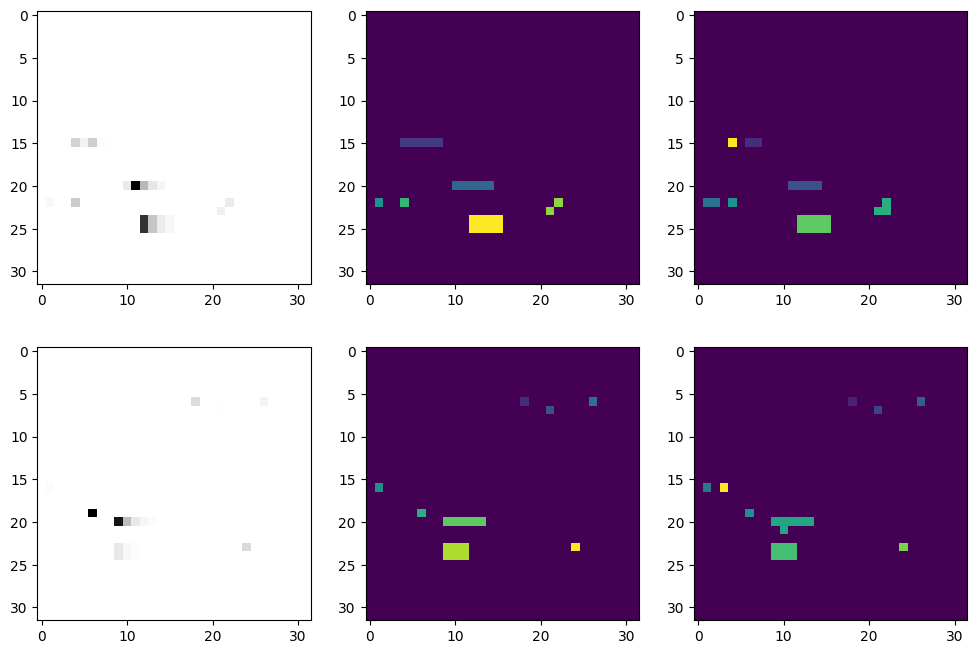

In [240]:
# DEBUG
num_example_to_display = 2
algo_sup_predicted_i = [6,11]
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for j in range(num_example_to_display):
    i = algo_sup_predicted_i[j]
    lpred, lmc = ccl_generator(pred_mask[i], val_mask[i])
    lpred = mc_label_convert(lpred, lmc)
    
    axs[j][0].imshow(val_img[i])
    axs[j][1].imshow(lmc)
    axs[j][2].imshow(lpred)

## Weights Analysis

In [205]:
conv_layers = []
for layer in model.layers:
    if "conv" in layer.name:
        conv_layers.append(layer)

In [207]:
conv_layers[-1].weights

[<tf.Variable 'conv2d_10/kernel:0' shape=(3, 3, 4, 3) dtype=float32, numpy=
 array([[[[-1.4035053 , -0.1691594 ,  0.5675656 ],
          [-1.1871152 ,  0.7690637 , -0.31745037],
          [-0.2992162 ,  0.22094612,  0.28447524],
          [-0.7458423 , -0.04057514,  0.6524691 ]],
 
         [[-0.5535876 , -0.14646491, -0.2700452 ],
          [-0.52451366, -0.6197916 ,  0.2833118 ],
          [ 0.07278182,  0.12390114,  0.06175253],
          [-0.38205716,  0.5824628 , -0.4543049 ]],
 
         [[-0.76782376,  0.1783538 , -0.16027261],
          [-1.964151  , -0.17168693,  0.66626644],
          [-0.07286557,  0.03414439,  0.3442133 ],
          [-0.2962506 , -0.14498486,  0.21456781]]],
 
 
        [[[ 0.31782386,  0.46076563, -0.79639685],
          [-1.7392197 ,  1.157387  , -1.0183835 ],
          [ 0.2372554 ,  0.00982026, -0.05115276],
          [-0.6411901 ,  0.47011515, -0.55396944]],
 
         [[-0.7550947 ,  0.7621841 , -0.8723858 ],
          [-2.5892565 , -0.27853298,  1.37